In [1]:
%load_ext autoreload
%autoreload 2

import sys
import time
from copy import copy
from pprint import pformat

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patches as patches
%matplotlib inline

from geodesic_agent import GeodesicAgent
from gridworld import Arena, Bottleneck, LinearChamber
from plot_utils import plot_replay, plot_traj, plot_need_gain
from RL_utils import oned_twod

*Open field*

*Bottleneck*

In [ ]:
d = np.load('Data/bottleneck_4rw_5cw.npz', allow_pickle=True)

# Bottleneck enclosure params
num_states = d['num_states']
room_width = d['room_width']
corridor_width = d['corridor_width']
height = d['height']

valid_states = Bottleneck.get_valid_states(room_width, corridor_width, height)
init_state_dist = np.zeros(num_states)
init_state_dist[valid_states] = 1 / (len(valid_states))
bottleneck = Bottleneck(room_width, corridor_width, height, init_state_distribution=init_state_dist)

# Actual data
replay_seqs = d['replay_seqs']
needs = d['needs']
gains = d['gains']
all_MEVBs = d['all_MEVBs']
backups = d['backups']

In [9]:
# Preprocessing
# Cut off replayed exps if ever there is 0 0 0
bad = np.zeros(3)
for step in range(replay_seqs.shape[0]):
    if np.allclose(replay_seqs[step, :], bad):
        break

replay_seqs = replay_seqs[:step, :]

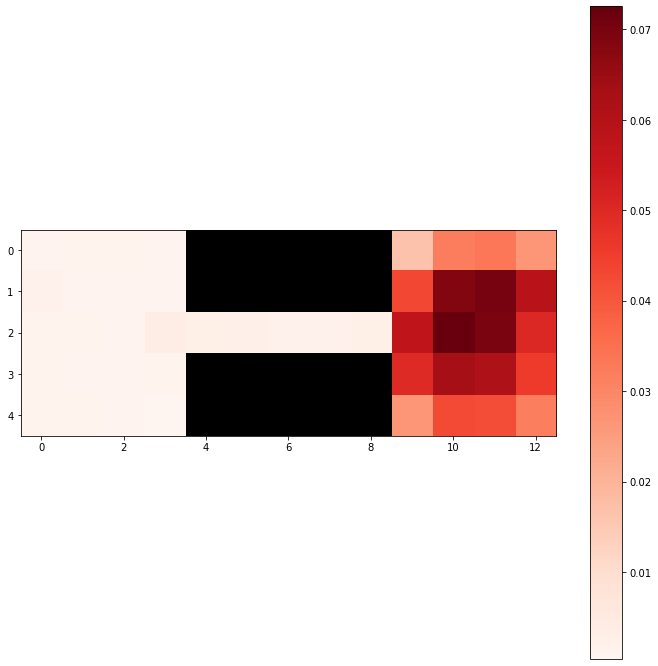

In [16]:
# Analyze
occ = np.zeros(num_states)
for i in range(replay_seqs.shape[0]):
    replay_step = replay_seqs[i, :]
    occ[replay_step[0]] += 1

occ /= replay_seqs.shape[0]

# Plot
palette = copy(plt.get_cmap('Reds'))
palette.set_under('black', 1.0)

# Grab boundaries
min_occ = np.min(occ[np.nonzero(occ)]) - 0.0001 # Dumb hack so that need = 0 states don't appear slightly red
max_occ = np.max(occ)

plt.figure(figsize=(12, 12))
plt.imshow(occ.reshape(height, 2 * room_width + corridor_width), cmap=palette, vmin=min_occ, vmax=max_occ)
plt.colorbar()

*Tunnel*

*Community graph*

In [11]:
# Load data
# first number: sources (0 = one source, 1 = some sources, 2 = all sources)
# second number: goals (0 = one goal, 1 = some goals, 2 = all goals)
# third number: learning rate
d = np.load('Data/cg_5c_3n_0.30_1_0.npz', allow_pickle=True)

# Bottleneck enclosure params
num_states = d['num_states']
neighbourhood_size = d['num_nbrs']
num_neighbourhoods = d['num_nbrhds']

# Actual data
replay_seqs = d['replay_seqs']
needs = d['needs']
trans_needs = d['trans_needs']
gains = d['gains']
all_MEVBs = d['all_MEVBs']
backups = d['backups']
num_replay_steps = replay_seqs.shape[0]
memories = d['memories']

In [12]:
# Visualize replay for community graph
replays = np.zeros((num_replay_steps, num_states))

for i in range(num_replay_steps):
    source, action, target = replay_seqs[i]
    if source == target:
        replays[i, source] = 0.75
    else:
        replays[i, source] = 0.5
        replays[i, target] = 1.0

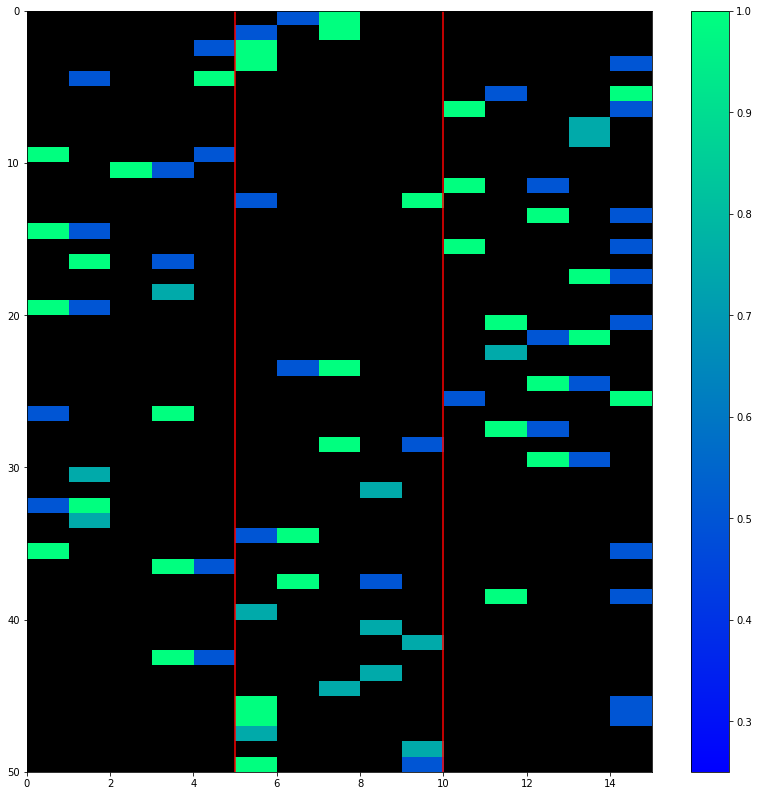

In [13]:
palette = copy(plt.get_cmap('winter'))
palette.set_under('black', 1.0)

plt.figure(figsize=(14, 14))
plt.imshow(replays, aspect='auto', extent=[0, num_states, num_replay_steps, 0], cmap=palette, vmin=0.25, vmax=1.0)
plt.ylim(50, 0)
plt.colorbar()
plt.axvline(5, color='r')
plt.axvline(10, color='r')

Text(0.5, 1.0, 'alpha = 1')

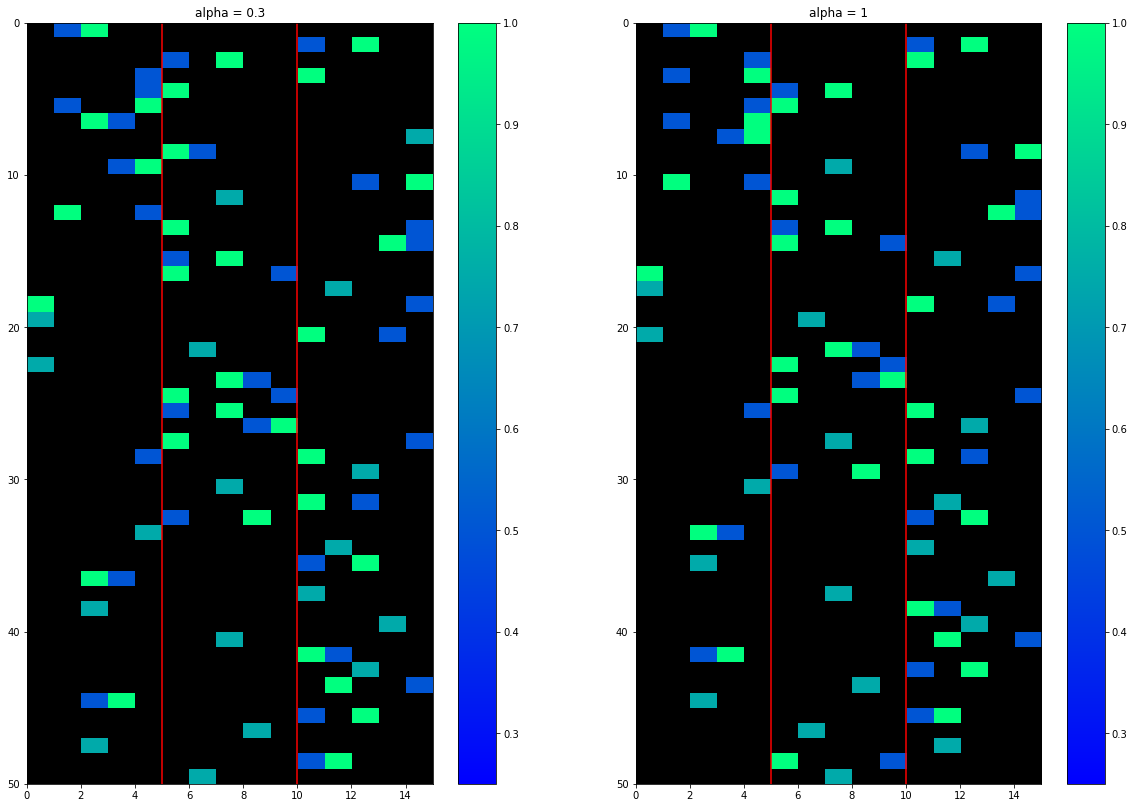

In [16]:
# Compare replay patterns across alpha = 1 and alpha = 0.3
plt.figure(figsize=(20, 14))

skey = 0 # How many sources
gkey = 1 # How many goals

# Alpha = 0.3
plt.subplot(1,2,1)

# Load data
# first number: sources (0 = one source, 1 = some sources, 2 = all sources)
# second number: goals (0 = one goal, 1 = some goals, 2 = all goals)
# third number: learning rate
d = np.load('Data/cg_5c_3n_0.30_%d_%d.npz' % (skey, gkey), allow_pickle=True)

# Bottleneck enclosure params
num_states = d['num_states']
neighbourhood_size = d['num_nbrs']
num_neighbourhoods = d['num_nbrhds']

# Actual data
replay_seqs = d['replay_seqs']
needs = d['needs']
trans_needs = d['trans_needs']
gains = d['gains']
all_MEVBs = d['all_MEVBs']
backups = d['backups']
num_replay_steps = replay_seqs.shape[0]
memories = d['memories']

# Visualize replay for community graph
replays = np.zeros((num_replay_steps, num_states))

for i in range(num_replay_steps):
    source, action, target = replay_seqs[i]
    if source == target:
        replays[i, source] = 0.75
    else:
        replays[i, source] = 0.5
        replays[i, target] = 1.0
        
palette = copy(plt.get_cmap('winter'))
palette.set_under('black', 1.0)

plt.imshow(replays, aspect='auto', extent=[0, num_states, num_replay_steps, 0], cmap=palette, vmin=0.25, vmax=1.0)
plt.ylim(50, 0)
plt.colorbar()
plt.axvline(5, color='r')
plt.axvline(10, color='r')
plt.title('alpha = 0.3')

# Alpha = 1.0
plt.subplot(1,2,2)

# Load data
# first number: sources (0 = one source, 1 = some sources, 2 = all sources)
# second number: goals (0 = one goal, 1 = some goals, 2 = all goals)
# third number: learning rate
d = np.load('Data/cg_5c_3n_%d_%d.npz' % (skey, gkey), allow_pickle=True)

# Bottleneck enclosure params
num_states = d['num_states']
neighbourhood_size = d['num_nbrs']
num_neighbourhoods = d['num_nbrhds']

# Actual data
replay_seqs = d['replay_seqs']
needs = d['needs']
trans_needs = d['trans_needs']
gains = d['gains']
all_MEVBs = d['all_MEVBs']
backups = d['backups']
num_replay_steps = replay_seqs.shape[0]
memories = d['memories']

# Visualize replay for community graph
replays = np.zeros((num_replay_steps, num_states))

for i in range(num_replay_steps):
    source, action, target = replay_seqs[i]
    if source == target:
        replays[i, source] = 0.75
    else:
        replays[i, source] = 0.5
        replays[i, target] = 1.0
        
palette = copy(plt.get_cmap('winter'))
palette.set_under('black', 1.0)

plt.imshow(replays, aspect='auto', extent=[0, num_states, num_replay_steps, 0], cmap=palette, vmin=0.25, vmax=1.0)
plt.ylim(50, 0)
plt.colorbar()
plt.axvline(5, color='r')
plt.axvline(10, color='r')
plt.title('alpha = 1')